In [258]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [259]:
global pi
pi = np.pi
global k
k = 1.380649 * 10**-23 #m**2 kg s**-2 K**-1

In [262]:
global m
global n
global T

m = 4.002602**1.66*10**(-27) #kg
n = 1 #mol
T = 273.15 #K

In [269]:
class my_pdf(st.rv_continuous):
    def _pdf(self,v):
        return n*(m/(2*pi*k*T))**(3/2)*4*pi*v**2*np.exp(-m*v**2/(2*k*T))

In [270]:
def createParticles(n):
    y = np.array([])
    m = my_pdf(a=0, b=10000)
    for _ in range(n):
        y=np.append(y,m.rvs())
    return y

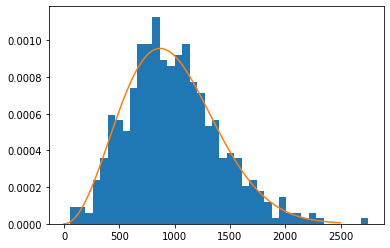

In [274]:
plt.hist(createParticles(500), bins=40, density=True)
v= np.arange(0,2500,1)
y= n*(m/(2*pi*k*T))**(3/2)*4*pi*v**2*np.exp(-m*v**2/(2*k*T))
plt.plot(v,y)
plt.show()

In [276]:
class particle:
    def __init__(self, m, x,y, vx, vy):
        self.m = m
        self.vx = vx
        self.vy = vy
    def getPosition():
        return (x,y)
    def getX():
        return x
    def getY():
        return y
    def getVelocity():
        return (vx,vy)
    def getVx():
        return vx
    def getVy():
        return vy